In [6]:
import numpy as np
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [7]:
def split_sequences(data, n_input, n_output):
    """Expects input data to be of shape (n_series, series_len, n_features)
    
       Returns:
           - X of shape (n_series * (series_len - (n_input + n_output) + 1), n_input, n_features)
           - Y of shape (n_series * (series_len - (n_input + n_output) + 1), n_output, n_features)
    """
    X = []
    Y = []
    # For each time series, split into sequences of x of length n_input and y of length n_output immediately following x
    for i in range(data.shape[0]):
        # series.shape: (series_len, n_features)
        series = data[i]
        series_len = series.shape[0]
        for j in range(series_len - (n_input + n_output) + 1):
            given_wind_start = j
            given_wind_end = given_wind_start + n_input
            x = series[given_wind_start:given_wind_end, :]
            pred_wind_start = given_wind_end
            pred_wind_end = pred_wind_start + n_output
            y = series[pred_wind_start:pred_wind_end, :]
            
            X.append(x)
            Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [8]:
data = [[i for i in range(1, 21)], [i for i in range(2, 22)], [i for i in range(3, 23)]]
data = np.array(data)
data = data.reshape(3, 20, 1)
print(data.shape)

# Sanity check split_sequences_function
X, Y = split_sequences(data, n_input=10, n_output=1)
print(X.shape)
print(Y.shape)
print(X[0], Y[0])
print(X[9], Y[9])
print(X[10], Y[10])

X, Y = split_sequences(data, n_input=10, n_output=2)
print(X.shape)
print(Y.shape)
print(X[0], Y[0])
print(X[8], Y[8])
print(X[9], Y[9])

(3, 20, 1)
(30, 10, 1)
(30, 1, 1)
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]] [[11]]
[[10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]] [[20]]
[[ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]] [[12]]
(27, 10, 1)
(27, 2, 1)
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]] [[11]
 [12]]
[[ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]] [[19]
 [20]]
[[ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]] [[12]
 [13]]


In [9]:
DATA_FILE = './data/processed/x_without_artifact.pt'

In [10]:
data = torch.load(DATA_FILE)

In [11]:
data = data.numpy()
print(data.shape)

(72, 50, 2)


In [12]:
rng = np.random.default_rng(seed=7)

In [13]:
idx = np.arange(72)
rng.shuffle(idx)

In [8]:
print(idx)

[28 46 12 16 40  4  1 10  6 24 65 47 36 64 26 45 69 63  0  2 55 32 39 70
 68 19 37 14 20 42 51 22 61 53 71 59 27 44  9  3 49 35 54 67 56 13 50 58
 17 18 31 62 34  5  8  7 33 57 30 15 29 38 48 23 52 25 43 66 60 21 41 11]


In [14]:
data_train = data[idx[0:50], :, :]
data_val = data[idx[50:61], :, :]
data_test = data[idx[61:72], :, :]
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(50, 50, 2)
(11, 50, 2)
(11, 50, 2)


In [15]:
# Define split sequence parameters
n_input = 10
n_output = 10
n_features = data.shape[-1]

In [16]:
X_train, Y_train = split_sequences(data_train, n_input=n_input, n_output=n_output)
# y_train = Y_train.reshape(-1, n_output * n_features)

In [17]:
X_val, Y_val = split_sequences(data_val, n_input=n_input, n_output=n_output)
# y_val = Y_val.reshape(-1, n_output * n_features)

In [18]:
X_test, Y_test = split_sequences(data_test, n_input=n_input, n_output=n_output)
# y_test = Y_test.reshape(-1, n_output * n_features)

In [19]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

print(X_test.shape)
print(Y_test.shape)

(1550, 10, 2)
(1550, 10, 2)
(341, 10, 2)
(341, 10, 2)
(341, 10, 2)
(341, 10, 2)


In [20]:
# Define model parameters
hidden_dim = 100

In [21]:
# Define model
model = Sequential()
model.add(LSTM(hidden_dim, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output * n_features))
model.add(Reshape((n_output, n_features)))
model.compile(optimizer='adam', loss='mse')

2021-12-03 00:14:56.547836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Define model training parameters
batch_size = 32
epochs = 2

In [23]:
# Fit model
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/2
49/49 [==============================] - 3s 14ms/step - loss: 1274.6420
Epoch 2/2
49/49 [==============================] - 1s 20ms/step - loss: 2.4137


In [24]:
# Evaluate model on validation data
model.evaluate(X_val, Y_val)

11/11 [==============================] - 0s 5ms/step - loss: 0.2068


0.2068072259426117

In [25]:
print(data_val.shape)

(11, 50, 2)


In [26]:
# Define generation parameters
to_gen_len = 500

In [27]:
# Generate full sequence
ex_i = 0
series = data_val[ex_i, 0:n_input, :]
for t in range(to_gen_len - (n_input + n_output) + 1):
    y_hat = model.predict(series[-n_input:, :][None, :, :])
    series = np.concatenate((series, y_hat[:, 0, :]), axis=0)

In [28]:
print(series)

[[ 40.07361  -70.38531 ]
 [ 40.083874 -70.365555]
 [ 40.089947 -70.34388 ]
 [ 40.093864 -70.31828 ]
 [ 40.092964 -70.29225 ]
 [ 40.089954 -70.26185 ]
 [ 40.08128  -70.22804 ]
 [ 40.06704  -70.19792 ]
 [ 40.03256  -70.19112 ]
 [ 40.043274 -70.205986]
 [ 39.75512  -70.6859  ]
 [ 39.78289  -70.66011 ]
 [ 39.794052 -70.64046 ]
 [ 39.78162  -70.58241 ]
 [ 39.79096  -70.57055 ]
 [ 39.787495 -70.53578 ]
 [ 39.883442 -70.7086  ]
 [ 39.951653 -70.800865]
 [ 39.94752  -70.67274 ]
 [ 39.918423 -70.56254 ]
 [ 39.918793 -70.582985]
 [ 39.8987   -70.57652 ]
 [ 39.888214 -70.56425 ]
 [ 39.87765  -70.551796]
 [ 39.866005 -70.541435]
 [ 39.87323  -70.59302 ]
 [ 39.915367 -70.73403 ]
 [ 39.949524 -70.78762 ]
 [ 39.95275  -70.72563 ]
 [ 39.941956 -70.67274 ]
 [ 39.929398 -70.65306 ]
 [ 39.91829  -70.63419 ]
 [ 39.915676 -70.63328 ]
 [ 39.912968 -70.62859 ]
 [ 39.90956  -70.62558 ]
 [ 39.92222  -70.67744 ]
 [ 39.95194  -70.76494 ]
 [ 39.973667 -70.794716]
 [ 39.977386 -70.76446 ]
 [ 39.969444 -70.72728 ]


In [29]:
print(data_val[ex_i])

[[ 40.07361  -70.38531 ]
 [ 40.083874 -70.365555]
 [ 40.089947 -70.34388 ]
 [ 40.093864 -70.31828 ]
 [ 40.092964 -70.29225 ]
 [ 40.089954 -70.26185 ]
 [ 40.08128  -70.22804 ]
 [ 40.06704  -70.19792 ]
 [ 40.03256  -70.19112 ]
 [ 40.043274 -70.205986]
 [ 40.07111  -70.213264]
 [ 40.10044  -70.20348 ]
 [ 40.11962  -70.20135 ]
 [ 40.133476 -70.20243 ]
 [ 40.147533 -70.21266 ]
 [ 40.162296 -70.221054]
 [ 40.172737 -70.223366]
 [ 40.18341  -70.22337 ]
 [ 40.190613 -70.23065 ]
 [ 40.19643  -70.24393 ]
 [ 40.201183 -70.25853 ]
 [ 40.217377 -70.272804]
 [ 40.233738 -70.28725 ]
 [ 40.24711  -70.28602 ]
 [ 40.26104  -70.27903 ]
 [ 40.271595 -70.273   ]
 [ 40.276817 -70.27252 ]
 [ 40.28213  -70.272   ]
 [ 40.28853  -70.27403 ]
 [ 40.300217 -70.2766  ]
 [ 40.31204  -70.2792  ]
 [ 40.30468  -70.278336]
 [ 40.297176 -70.27308 ]
 [ 40.285847 -70.272995]
 [ 40.277576 -70.280716]
 [ 40.26903  -70.28869 ]
 [ 40.271126 -70.297455]
 [ 40.28041  -70.30171 ]
 [ 40.291386 -70.307434]
 [ 40.29607  -70.30343 ]


In [30]:
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
from matplotlib import colors
from constants import *

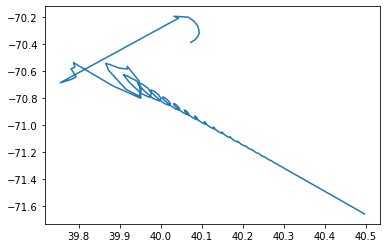

In [31]:
plt.plot(series[:, 0], series[:, 1])

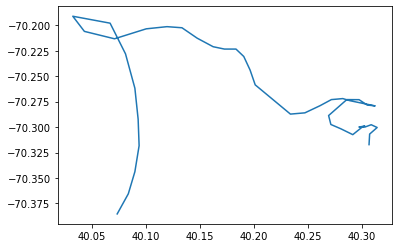

In [32]:
plt.plot(data_val[ex_i, :, 0], data_val[ex_i, :, 1])

In [110]:
# Generate full sequence
ex_i = 5
series = data_val[ex_i, 0:n_input, :]
for t in range(to_gen_len - (n_input + n_output) + 1):
    y_hat = model.predict(series[-n_input:, :][None, :, :])
    series = np.concatenate((series, y_hat[:, 0, :]), axis=0)

In [111]:
print(series)

[[ 40.040333 -70.6972  ]
 [ 40.046185 -70.6972  ]
 [ 40.048237 -70.697914]
 [ 40.049282 -70.698364]
 [ 40.050034 -70.7048  ]
 [ 40.0618   -70.71644 ]
 [ 40.07078  -70.724594]
 [ 40.07082  -70.73325 ]
 [ 40.077454 -70.74449 ]
 [ 40.086582 -70.751816]
 [ 39.93983  -70.66826 ]
 [ 39.984554 -70.65347 ]
 [ 39.982784 -70.6556  ]
 [ 39.970722 -70.68088 ]
 [ 39.970036 -70.68516 ]
 [ 39.970425 -70.687904]
 [ 39.96601  -70.68311 ]
 [ 39.969296 -70.68459 ]
 [ 39.954674 -70.68089 ]
 [ 39.939487 -70.67382 ]
 [ 39.931454 -70.66325 ]
 [ 39.9306   -70.66281 ]
 [ 39.928413 -70.6687  ]
 [ 39.930313 -70.67739 ]
 [ 39.927937 -70.67999 ]
 [ 39.926865 -70.67973 ]
 [ 39.92436  -70.67804 ]
 [ 39.921482 -70.67828 ]
 [ 39.918316 -70.678795]
 [ 39.916122 -70.67941 ]
 [ 39.914173 -70.679985]
 [ 39.914505 -70.68259 ]
 [ 39.915485 -70.6864  ]
 [ 39.916107 -70.689995]
 [ 39.91578  -70.69185 ]
 [ 39.915287 -70.692764]
 [ 39.91489  -70.69376 ]
 [ 39.915005 -70.69567 ]
 [ 39.915115 -70.697914]
 [ 39.9154   -70.70016 ]


In [112]:
print(data_val[ex_i])

[[ 40.040333 -70.6972  ]
 [ 40.046185 -70.6972  ]
 [ 40.048237 -70.697914]
 [ 40.049282 -70.698364]
 [ 40.050034 -70.7048  ]
 [ 40.0618   -70.71644 ]
 [ 40.07078  -70.724594]
 [ 40.07082  -70.73325 ]
 [ 40.077454 -70.74449 ]
 [ 40.086582 -70.751816]
 [ 40.093983 -70.7506  ]
 [ 40.0967   -70.741585]
 [ 40.099705 -70.73329 ]
 [ 40.10259  -70.73802 ]
 [ 40.11936  -70.744194]
 [ 40.138157 -70.74609 ]
 [ 40.146183 -70.748764]
 [ 40.147488 -70.75258 ]
 [ 40.14813  -70.76427 ]
 [ 40.156693 -70.77881 ]
 [ 40.172096 -70.78828 ]
 [ 40.189888 -70.78568 ]
 [ 40.202694 -70.78723 ]
 [ 40.213192 -70.792534]
 [ 40.225895 -70.79824 ]
 [ 40.241505 -70.7984  ]
 [ 40.254795 -70.79711 ]
 [ 40.262516 -70.799225]
 [ 40.26227  -70.805565]
 [ 40.267544 -70.8184  ]
 [ 40.282467 -70.82604 ]
 [ 40.299583 -70.8234  ]
 [ 40.313587 -70.82042 ]
 [ 40.319717 -70.82267 ]
 [ 40.325188 -70.83082 ]
 [ 40.336628 -70.83562 ]
 [ 40.354237 -70.83122 ]
 [ 40.3533   -70.82085 ]
 [ 40.331284 -70.809   ]
 [ 40.307518 -70.80504 ]


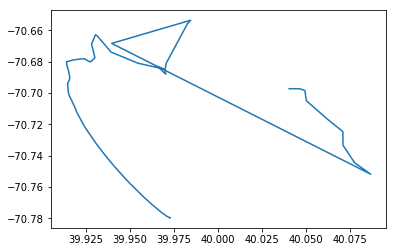

In [113]:
plt.plot(series[:, 0], series[:, 1])

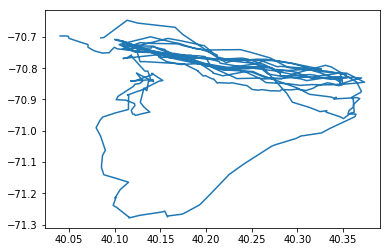

In [114]:
plt.plot(data_val[ex_i, :, 0], data_val[ex_i, :, 1])